# LSTM

In [63]:
# utility
import numpy as np 
import pandas as pd 
import string
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# model 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
import keras
from keras.utils.np_utils import to_categorical

#nltk and sklearn
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

### Data

In [64]:
orig_df=pd.read_csv('../../../Data/Fake news detection/data.csv')
orig_df.drop(orig_df.columns[[0,1]], axis = 1, inplace = True)
orig_df["Body"] = orig_df["Body"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [65]:
df = orig_df
df.head()

,Body,Label
0,Image copyright Getty Images\nOn Sunday mornin...,1
1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,The feud broke into public view last week when...,1
3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,"Country singer Jason Aldean, who was performin...",1


In [66]:
sentiment =  df['Label'].values

In [67]:
df.groupby('Label').describe()

Body                                                               
      count unique                                                top freq
Label                                                                     
0      2137   1194  A Potato Battery Can Light up a Room for Over ...  143
1      1872   1671  Chat with us in Facebook Messenger. Find out w...   61

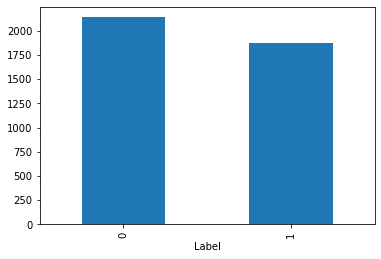

In [68]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [69]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

0    2137
1    1872
Name: Label, dtype: int64

### Balanced Data

In [70]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [71]:
new_text, new_label = balanceClasses(df['Body'], df['Label'])

In [72]:
data = pd.DataFrame(new_text)
data.columns = ['Body']
data['Label'] = new_label
data = pd.concat([df, data])

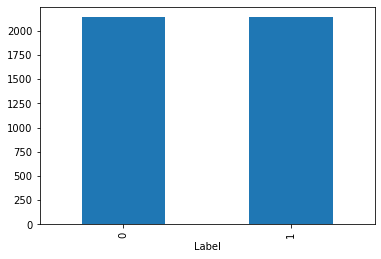

In [73]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [74]:
data.Label.value_counts()

0    2137
1    2136
Name: Label, dtype: int64

In [75]:
# For entire dataset sentences for each labels 
data.Label.value_counts()

0    2137
1    2136
Name: Label, dtype: int64

In [76]:

data=data.sample(frac=1).reset_index(drop=True)
data

,Body,Label
0,Week 5 Rankings (2017): Top 20 Tight Ends\n(Be...,0
1,Acid Attacks: Hell In A Bottle\n(Before It's N...,0
2,"Hurun valued the wealth of Mr. Xu, chairman an...",1
3,LONDON (Reuters) - The British government put ...,1
4,FRANKFURT (Reuters) - German authorities arres...,1
...,...,...
4268,ISTANBUL — The United States said on Sunday th...,1
4269,"(CNN) For most women, access to reproductive a...",1
4270,Red Flag Warning: These California Wildfires A...,0
4271,"Vietnam Is in Great Danger, You Must Publish a...",0


### Data Preprocessing

In [77]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [78]:
def CleanTokenize(df):
    tweets = list()
    lines = data["Body"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            line = clean_text(line)
        else:
            continue
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        tweets.append(words)
    return tweets

def Tokenize(df):
    tweets = list()
    lines = data["Body"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            # tokenize the text
            tokens = word_tokenize(line)
        else:
            continue

        tweets.append(tokens)
    return tweets

tweets = CleanTokenize(data)
#tweets = Tokenize(data)


(-0.5, 999.5, 499.5, -0.5)

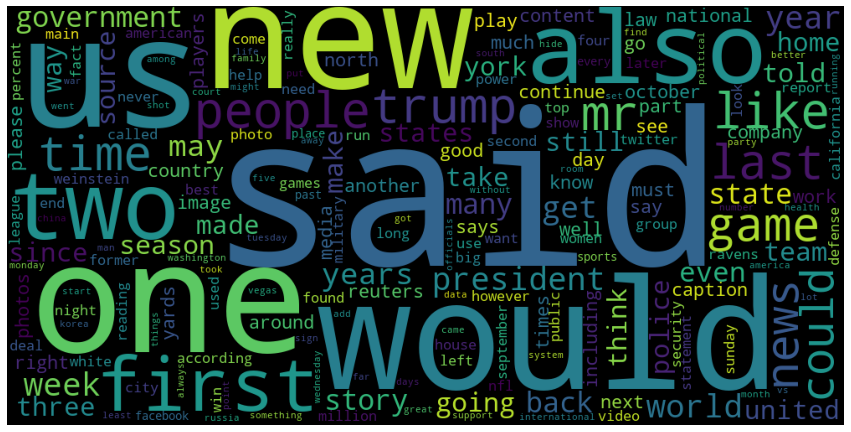

In [79]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['Label'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Splitting data

In [80]:
validation_split = 0.1
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

le = LabelEncoder()
sentiment = le.fit_transform(sentiment)
# transfor from a array to a vector
sentiment = sentiment.reshape(-1,1)


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


unique tokens -  49054
vocab size - 49055


In [81]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (3846, 25)
Shape of y_train: (3846, 2)
Shape of X_test_pad: (427, 25)
Shape of y_test: (427, 2)


### Word2vec Word Embedding

In [82]:
from gensim import models
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [83]:
embedding_dim = 300

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)
print()

In [84]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [85]:
from tensorflow.keras import optimizers
def createModel(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.50))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate=1e-3), metrics=['acc'])
    return model

model = createModel(embedding_layer)
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 300)           14716500  
                                                                 
 lstm_22 (LSTM)              (None, 256)               570368    
                                                                 
 dense_22 (Dense)            (None, 2)                 514       
                                                                 
Total params: 15,287,382
Trainable params: 570,882
Non-trainable params: 14,716,500
_________________________________________________________________


In [86]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/6
121/121 - 24s - loss: 0.2627 - acc: 0.8983 - val_loss: 0.4365 - val_acc: 0.8829 - 24s/epoch - 197ms/step
Epoch 2/6
121/121 - 20s - loss: 0.1289 - acc: 0.9581 - val_loss: 0.2212 - val_acc: 0.9415 - 20s/epoch - 166ms/step
Epoch 3/6
121/121 - 22s - loss: 0.0945 - acc: 0.9680 - val_loss: 0.1398 - val_acc: 0.9485 - 22s/epoch - 184ms/step
Epoch 4/6
121/121 - 21s - loss: 0.0725 - acc: 0.9763 - val_loss: 0.1223 - val_acc: 0.9649 - 21s/epoch - 173ms/step
Epoch 5/6
121/121 - 21s - loss: 0.0536 - acc: 0.9839 - val_loss: 0.1879 - val_acc: 0.9649 - 21s/epoch - 173ms/step
Epoch 6/6
121/121 - 20s - loss: 0.0450 - acc: 0.9857 - val_loss: 0.1082 - val_acc: 0.9719 - 20s/epoch - 168ms/step


In [87]:
results = model.evaluate(X_test_pad, y_test, batch_size=32)

14/14 [==============================] - 1s 52ms/step - loss: 0.1082 - acc: 0.9719


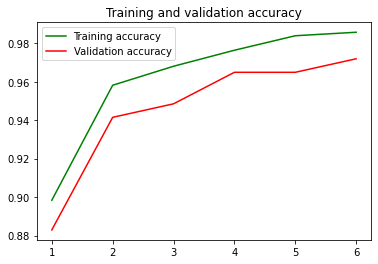

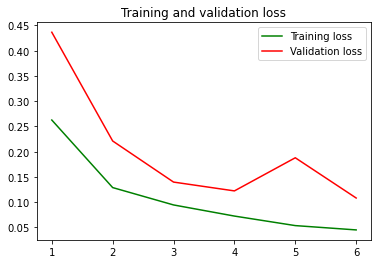

In [88]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 10 Fold cross validation

In [89]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold
# KFold cross-validation
kFold = 10
scores = []
validation_split = 0.1
max_length = 25
results = []
train_results = []
print("LSTM with Word2Vec: ")
for i in range(kFold):
    print("Fold: ", i+1)
    prediction_val = []
    Y_test = []
    scores=[]
    random_shuff = random.randint(1, 7000)
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(lines_pad, to_categorical(sentiment), test_size=0.10, shuffle = True, random_state=random_shuff)
    model = createModel(embedding_layer)
    history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=1)
    
    print("Results for current fold:")
    print("Evaluation using training data")
    train_results.append(model.evaluate(X_train_pad, y_train, batch_size=128))
    print("Evaluation using testing data")
    results.append(model.evaluate(X_test_pad, y_test, batch_size=128))
    
    y_pred = model.predict(X_test_pad)
    for p in y_pred:
        prediction_val.append(np.argmax(p))
    for t in y_test:
        Y_test.append(np.argmax(t))
    scoreValue = accuracy_score(Y_test,prediction_val)
    scores.append(scoreValue)



LSTM with Word2Vec: 
Fold:  1
Epoch 1/6
121/121 [==============================] - 27s 181ms/step - loss: 0.2787 - acc: 0.8960 - val_loss: 0.1911 - val_acc: 0.9322
Epoch 2/6
121/121 [==============================] - 21s 177ms/step - loss: 0.1356 - acc: 0.9514 - val_loss: 0.1039 - val_acc: 0.9696
Epoch 3/6
121/121 [==============================] - 22s 179ms/step - loss: 0.0933 - acc: 0.9693 - val_loss: 0.0918 - val_acc: 0.9650
Epoch 4/6
121/121 [==============================] - 21s 174ms/step - loss: 0.0721 - acc: 0.9748 - val_loss: 0.0916 - val_acc: 0.9626
Epoch 5/6
121/121 [==============================] - 22s 185ms/step - loss: 0.0586 - acc: 0.9776 - val_loss: 0.1016 - val_acc: 0.9743
Epoch 6/6
121/121 [==============================] - 23s 186ms/step - loss: 0.0476 - acc: 0.9849 - val_loss: 0.1284 - val_acc: 0.9673
Results for current fold:
Evaluation using training data
31/31 [==============================] - 3s 92ms/step - loss: 0.0163 - acc: 0.9930
Evaluation using testing d

121/121 [==============================] - 22s 181ms/step - loss: 0.0424 - acc: 0.9854 - val_loss: 0.1020 - val_acc: 0.9743
Results for current fold:
Evaluation using training data
31/31 [==============================] - 3s 86ms/step - loss: 0.0228 - acc: 0.9922
Evaluation using testing data
4/4 [==============================] - 0s 107ms/step - loss: 0.1020 - acc: 0.9743
Fold:  9
Epoch 1/6
121/121 [==============================] - 24s 177ms/step - loss: 0.2760 - acc: 0.8928 - val_loss: 0.1324 - val_acc: 0.9533
Epoch 2/6
121/121 [==============================] - 22s 180ms/step - loss: 0.1334 - acc: 0.9537 - val_loss: 0.2019 - val_acc: 0.9369
Epoch 3/6
121/121 [==============================] - 22s 183ms/step - loss: 0.0905 - acc: 0.9683 - val_loss: 0.1010 - val_acc: 0.9673
Epoch 4/6
121/121 [==============================] - 21s 173ms/step - loss: 0.0732 - acc: 0.9782 - val_loss: 0.1077 - val_acc: 0.9696
Epoch 5/6
121/121 [==============================] - 22s 178ms/step - loss: 0.0

In [90]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.9693925261497498


### Confusion matrix

In [91]:
#for last fold
results2 = confusion_matrix(Y_test,prediction_val)
print ('Confusion Matrix :')
print(results2)
print ('Accuracy Score :',accuracy_score(Y_test,prediction_val))
print ('Report : ')
print (classification_report(Y_test,prediction_val))

Confusion Matrix :
[[202   7]
 [  1 218]]
Accuracy Score : 0.9813084112149533
Report : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       209
           1       0.97      1.00      0.98       219

    accuracy                           0.98       428
   macro avg       0.98      0.98      0.98       428
weighted avg       0.98      0.98      0.98       428

